Research Paper: 'On Spectral Clustering: Analysis and an algorithm' by Andrew Y. Ng, Michael I. Jordan, Yair Weiss 
https://papers.nips.cc/paper/2092-on-spectral-clustering-analysis-and-an-algorithm.pdf

### Replicating the Spectral Clustering Algorithm from the above paper.
Note: The steps of the algorithm are mentioned as comments in the function calls. The data is a text file with comma separated edge list. Each line in the file must contain a pair of vertices defining an edge between them.

In [1]:
#!/usr/bin/env python3

#Ignore deprecation warnings for few functions used
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing libraries
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
#Read edge list file
def read_node_edge(file_path, delimiter = ''):
    
    with open(file_path, 'r') as f:
        
        #Check if delimiter is empty or not
        if delimiter != '':
            df_links = pd.DataFrame(l.rstrip().split(delimiter) for l in f)
        else:
            df_links = pd.DataFrame(l.rstrip().split() for l in f)
            
    return(df_links)

In [4]:
#Preprocess edge list
def data_preprocess(df_links):

    #Convert string data (if any) into integer
    df_links = df_links.astype(int)

    #Convert the dataframe of edges between journals to list of tuple that determine the connection between edges
    edges = list(zip(df_links[0], df_links[1]))

    #Extract unique nodes
    nodes = np.unique(np.asarray(edges))
    
    print('\tNumber of unique nodes is {0}'.format(len(nodes)))
    
    #Determine the maximum value of the nodes
    max_value_nodes = max(nodes)
    
    return(edges, nodes, max_value_nodes)

In [5]:
#Construct affinity matrix_A - matrix_A_ij = 1 if edge link exists between node i and node j
def create_affinity_matrix(max_value_nodes, edges):
    
    #Initialize empty matrix with all elements as 0 and size of the matrix as the number of nodes 
    matrix_A = np.zeros([max_value_nodes, max_value_nodes])
    
    #Assign 1 if an edge exists between row index and column index
    for edge in edges:
        matrix_A[edge[0] - 1, edge[1] - 1] = 1
    
    #Return Affinity Matrix
    return(matrix_A)

In [6]:
#Construct diagonal matrix_D: diagonal matrix whose (i,i)-element is the sum of matrix_A's i-th column
def create_diag_matrix(matrix_A):
    
    #Assign sum of elements across each column to the diagonal of a matrix
    matrix_D = np.diag(np.sum(matrix_A, axis = 1))
    
    #Return diagonal degree matrix
    return(matrix_D)

In [7]:
#Create normalized laplacian matrix_L: (matrix_D ^ (-1 / 2)) * matrix_A * (matrix_D ^ (-1 / 2))
def create_norm_laplacian(matrix_D, matrix_A):
    
    #Determine matrix_L based on the value of determinant of matrix_D (check for singular matrix)
    if np.linalg.det(matrix_D) != 0:
        matrix_D_inv = np.linalg.inv(np.sqrt(matrix_D))        
    else:
        matrix_D_inv = np.linalg.pinv(np.sqrt(matrix_D)) # Implicit decomposition of singular vector/matrix to find its inverse
    
    matrix_L = np.dot(np.dot(matrix_D_inv, matrix_A), matrix_D_inv)

    return(matrix_L)

In [8]:
#Extract the eignevalues (ascending order) and normalized (unit “length”) eigenvectors of L 
def extract_eigen_values(matrix_L, max_value_nodes):
    
    #Calculate eigenvalues and eigenvectors of normalized laplacian matrix
    eigen_values, eigen_vectors = scipy.linalg.eigh(matrix_L)
    
    #Plot distribution of eigenvalues
    plt.figure(figsize = (15, 7))
    plt.scatter(range(1, max_value_nodes + 1), eigen_values)
    plt.xlabel('Nodes')
    plt.ylabel('Eigenvalues')
    plt.title('Eigenvalues Distribution')
    plt.show()
    
    return(eigen_values, eigen_vectors)

In [9]:
#Execute K-means algorithm, and save it's result on label to visual clusters
def kmeans(nodes, edges, eigen_values, matrix_L, size_of_node, k_val, num_of_iter):
    
    #Determine optimal value for number of clusters, k
    k = np.argmin(np.ediff1d(np.flipud(eigen_values))) + 1
    
    print('\tOptimal value of k is {0}'.format(k))
    
    #K-means execution
    kmeans = KMeans(n_clusters = k, random_state = 1234).fit(matrix_L)

    #Store the cluster label(s)
    cluster_labels = kmeans.labels_
    
    #Plot clusters    
    plot_graph(nodes, edges, size_of_node, k_val, num_of_iter, cluster_labels)  

In [10]:
#Carry out Spectral Clustering algorithm
def spectral_clustering(X, L, max_value_nodes):
    
    #Extract eigenvector corresponding to second smallest eigenvalue of matrix L, also known as fiedler vector
    fiedler_vector = X[:, 1]

    #Plot the sparsity pattern and sorted fiedler vector
    fig = plt.figure(figsize = (25, 10), dpi= 300, facecolor = 'w', edgecolor = 'k')
    
    #Plot normalized laplacian matrix values to determine the sparsity pattern in the clusters
    plt.subplot(1, 2, 1)
    plt.spy(L) 
    plt.title('Sparsity Pattern')
    
    #Plot fiedler vector values to identify possible clusters
    plt.subplot(1, 2, 2)
    plt.scatter(range(1, max_value_nodes + 1), np.sort(fiedler_vector))
    plt.xlabel('Nodes')
    plt.ylabel('Fiedler Vector Values')
    plt.title('Fiedler Vector Distribution')

    plt.show()

In [11]:
#Visualize graph 
def plot_graph(nodes, edges, size_of_node, k_val, num_of_iter, cluster_labels = 'b'):
    
    #Initilize networkx graph object
    G = nx.Graph()
    
    #Store node list in object
    G.add_nodes_from(nodes)
    
    #Store edge list in object
    G.add_edges_from(edges)
    
    #Plot networkx graph
    nx.draw(G, node_size = size_of_node, pos = nx.spring_layout(G, k = k_val, iterations = num_of_iter), node_color = cluster_labels, with_labels = False)
    
    plt.show()


Step 1: Reading the list of edges into a dataframe...
	The delimiter for the current edge list file is ,
	Enter the delimiter of the file (eg. ','): ,

Step 2: Cleaning the edge list, determining unique nodes and its maximum value...
	Number of unique nodes is 241

Step 3: Visualizing the node and edges using NetworkX...
	The suitable value of size of node is 20, distance between each node is 0.05 and 
	number of iterations is 20 for the current dataset
	Enter the size of node: 20
	Enter the distance between each node: 0.05
	Enter the number of iterations: 20


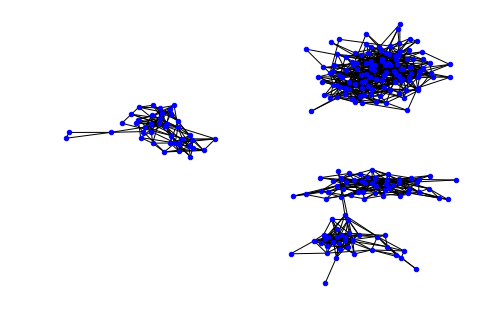

In [12]:
print('\nStep 1: Reading the list of edges into a dataframe...')
print('\tThe delimiter for the current edge list file is ,')
delimiter = input("\tEnter the delimiter of the file (eg. ','): ")
df_links = read_node_edge('example1.dat', delimiter)

print('\nStep 2: Cleaning the edge list, determining unique nodes and its maximum value...')
edges, nodes, max_value_nodes = data_preprocess(df_links)

print('\nStep 3: Visualizing the node and edges using NetworkX...')
print('\tThe suitable value of size of node is 20, distance between each node is 0.05 and \n\tnumber of iterations is 20 for the current dataset')
size_of_node = float(input('\tEnter the size of node: '))
k_val = float(input('\tEnter the distance between each node: '))
num_of_iter = int(input('\tEnter the number of iterations: '))
plot_graph(nodes, edges, size_of_node, k_val, num_of_iter)


Step 4: Creating Affinity Matrix A...

Step 5: Creating the Diagonal Degree Matrix D...

Step 6: Creating the Normalized Laplacian Matrix L...

Step 7: Extracting eigenvalues in ascending order and corresponding eigenvectors...


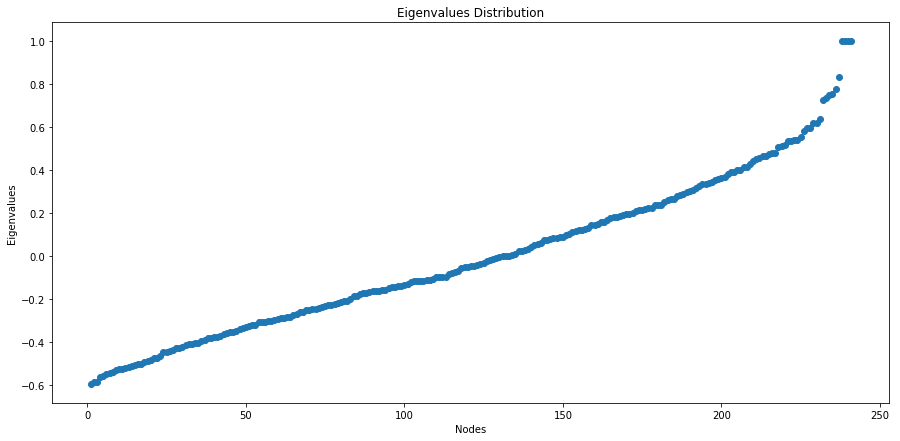


Step 8: Calculating k in K-means algorithm and visualizing clusters using generated labels...
	Optimal value of k is 4


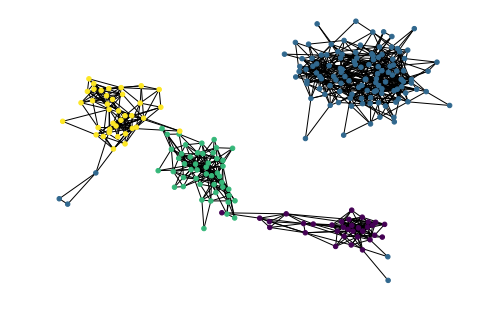

In [13]:
print('\nStep 4: Creating Affinity Matrix A...')
matrix_A = create_affinity_matrix(max_value_nodes, edges)

print('\nStep 5: Creating the Diagonal Degree Matrix D...')
matrix_D = create_diag_matrix(matrix_A)

print('\nStep 6: Creating the Normalized Laplacian Matrix L...')
matrix_L = create_norm_laplacian(matrix_D, matrix_A)

print('\nStep 7: Extracting eigenvalues in ascending order and corresponding eigenvectors...')
w, X = extract_eigen_values(matrix_L, max_value_nodes) 

print('\nStep 8: Calculating k in K-means algorithm and visualizing clusters using generated labels...')
kmeans(nodes, edges, w, matrix_L, size_of_node, k_val, num_of_iter)


Step 9: Calculating fiedler vector and plotting sparsity pattern and fiedler vector


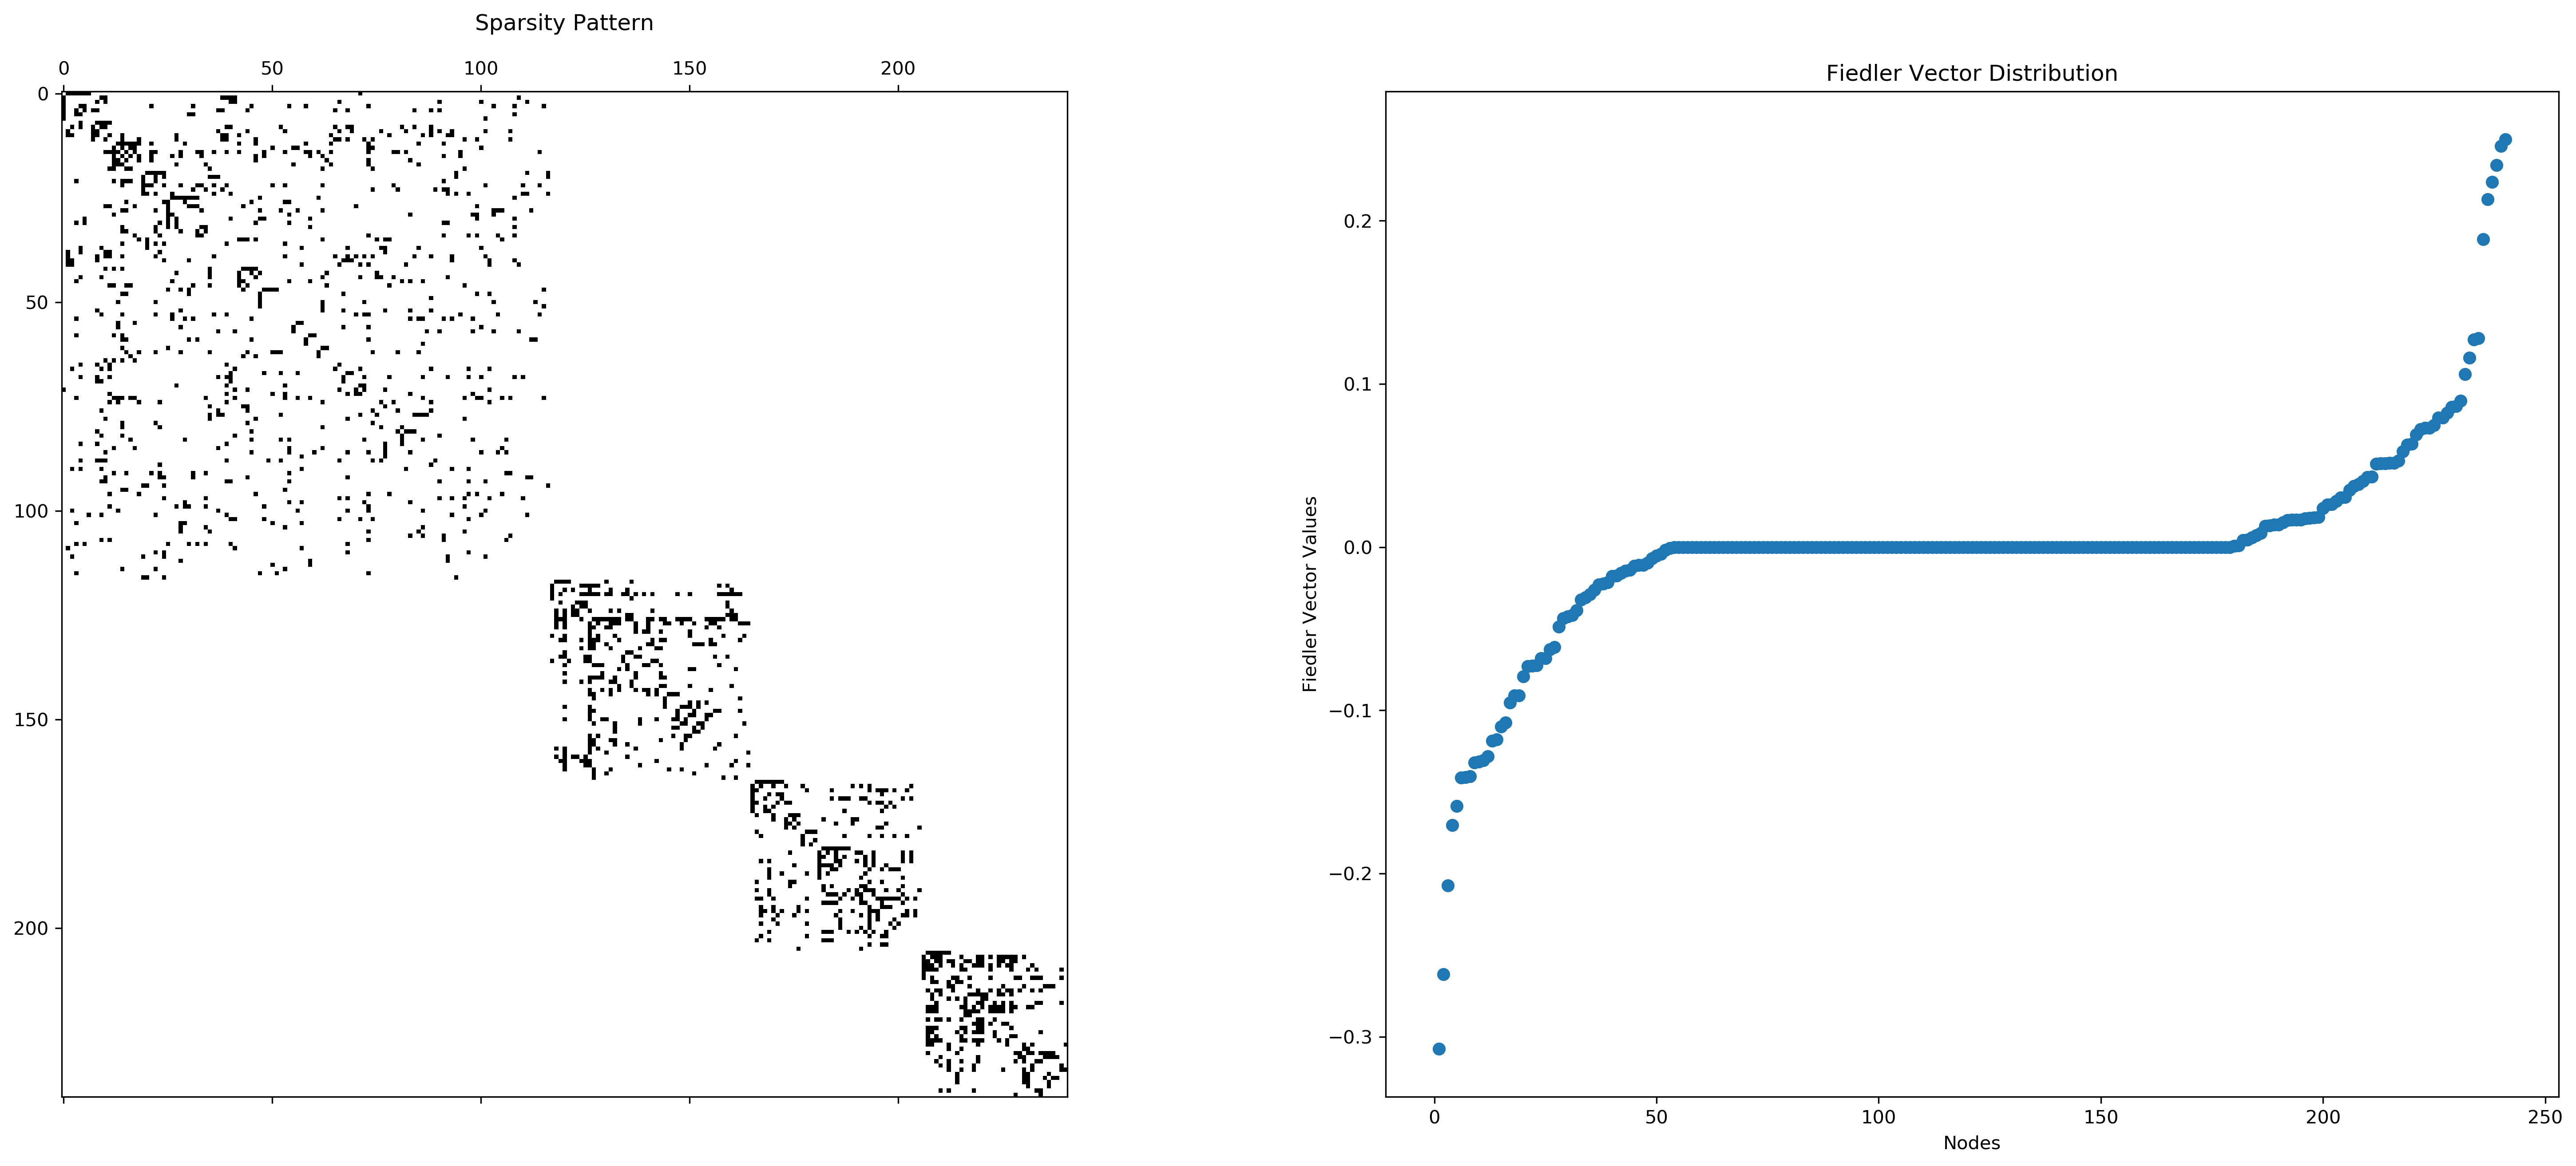

In [14]:
print('\nStep 9: Calculating fiedler vector and plotting sparsity pattern and fiedler vector')
spectral_clustering(X, matrix_L, max_value_nodes)

<b>Interpretation of above plots:</b><br><br>
As we can see from the sparsity pattern, there are four distinct clusters similar to what is defined in the original dataset.<br><br>
The fiedler vector is slightly unclear. If the eigen gap is relatively separate, i.e. λk+1>0, then we might be able to reconstruct the four clsuters because the separation of the first k eigenvectors of L will be close to E as mentioned in the paper.

<b>Observations on Spectral Clustering:</b><br>
Advantages:<ul>
<li>Spectral clustering could define complex boundaries unlike K-means which works on the assumption that the points assigned to a cluster are spherical about the cluster center (centroid).
<li>It worked well with a small number of clusters.
<li>Speed of execution was higher as compared to K-means for relatively sparse affinity matrix.</ul>
Disadvantages:<ul>
<li>I tried working with datasets having nearly 1000+ nodes with more than 10 clusters defined by the K-means algorithm. The sparsity pattern and fiedler vector graphs did not clearly define the boundaries of those clusters. I believe that this algorithm might not work well for larger number of clusters since with an inrease in the value of k (number of clusters), it becomes difficult to distinguish between the cluster boundaries.
<li>Time complexity increased with increase in data since the algorithm requires calculation of eigenvalues and correpending vectors for each data point.</ul>